# Прогнозирование уровня сложности фильмов на английском.

**Цель работы**: разработать модель для прогнозирования уровня сложности фильмов на английском языке на основе файлов с субтитрами.

**Ход работы:**

- Сбор данные: Фильмы и их оценки уровня сложности представлены в файле "movies_labels.xlsx". Каждые субтитры представлены в отдельных файлах в формате SRT. Необходимо объединить данные в один датафрейм для последующего анализа.

- Предобработка данных и исследовательский анализ: Проведем предобработку данных, включающую очистку текста от нежелательных символов, удаление стоп-слов, лемматизацию и т.д. Эти шаги помогут улучшить качество моделирования. Изучим распределение уровней сложности фильмов. Также в выборке слишком мало наблюдений, это может стать проблемой при обучении модели. В целевом признаке присутствуют смежные классы, которые необходимо обработать или преобразовать.

- Обучение моделей: На предобработанных данных обучим модели случайного леса и градиентного бустинга с использованием библиотеки CatBoost, сравним их точность и выберем наиболее подходящую.

###  Выгрузка данных

Импортируем все необходимые для работы библиотеки.

In [7]:
!pip install Path

In [8]:
!pip install pysrt

In [9]:
!pip install openpyxl

In [10]:
!pip install optuna

In [7]:
!pip install catboost

     ------------------------------------ 101.0/101.0 MB 119.4 kB/s eta 0:00:00
  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)


In [2]:
import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import difflib
from pathlib import Path
import pysrt
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer

from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import optuna
from sklearn.metrics import balanced_accuracy_score, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt
import optuna
from sklearn.model_selection import cross_val_score

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\banan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\banan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\banan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Считаем файл с данными, сохраним в переменной df и выведем общую информацию.

In [3]:
df = pd.read_excel('movies_labels.xlsx', index_col=0)

In [4]:
df.head(15)

,Movie,Level
id,,
0,10_Cloverfield_lane(2016),B1
1,10_things_I_hate_about_you(1999),B1
2,A_knights_tale(2001),B2
3,A_star_is_born(2018),B2
4,Aladdin(1992),A2/A2+
5,All_dogs_go_to_heaven(1989),A2/A2+
6,An_American_tail(1986),A2/A2+
7,Babe(1995),A2/A2+
8,Back_to_the_future(1985),A2/A2+


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 241 entries, 0 to 240
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Movie   241 non-null    object
 1   Level   241 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


Датафрейм содержит 241 фильм.

Добавим субтитры в датафрейм. Для чтения файлов с субтитрами в формате SRT воспользуемся библиотекой pysrt. Для нахождения соответствий между фильмами и субтитрами по названиям, воспользуемся методом `get_close_matches` из библиотеки `difflib`.

In [6]:
path = Path('Subtitles_all/Subtitles')

In [7]:
for index, row in df.iterrows():
    movie_title = row['Movie']
    
    closest_match = difflib.get_close_matches(movie_title, [subtitle_file.stem for subtitle_file in path.glob('*.srt')], n=1)
    
    if closest_match:
        subtitle_name = closest_match[0]
        subtitle_file = path / (subtitle_name + '.srt')
        
        subtitles = pysrt.open(subtitle_file, encoding='latin1')
        
        subtitle_text = ' '.join([subtitle.text for subtitle in subtitles])
        
        df.at[index, 'Subtitles'] = subtitle_text
    else:
        df.at[index, 'Subtitles'] = None

Выведем первые 15 строк полученного датафрейма и проверим, нет ли пропущенных значений. 

In [8]:
df.head(15)

,Movie,Level,Subtitles
id,,,
0,10_Cloverfield_lane(2016),B1,"<font color=""#ffff80""><b>Fixed & Synced by boz..."
1,10_things_I_hate_about_you(1999),B1,"Hey! I'll be right with you. So, Cameron. Here..."
2,A_knights_tale(2001),B2,Resync: Xenzai[NEF]\nRETAIL Should we help him...
3,A_star_is_born(2018),B2,"- <i><font color=""#ffffff""> Synced and correct..."
4,Aladdin(1992),A2/A2+,"<i>Oh, I come from a land\nFrom a faraway plac..."
5,All_dogs_go_to_heaven(1989),A2/A2+,CAPTIONING MADE POSSIBLE BY\nMGM HOME ENTERTAI...
6,An_American_tail(1986),A2/A2+,(INDISTINCT CONVERSATION) (ALL LAUGHING) MAMA:...
7,Babe(1995),A2/A2+,This is a tale about<br/>an unprejudiced heart...
8,Back_to_the_future(1985),A2/A2+,"October is inventory time, so right now, Statl..."


In [9]:
df['Subtitles'].isna().sum()

0

Все субтитры загружены в датафрейм, перейдем к предобработке и исследовательскому анализу.

### Предобработка и исследовательский анализ данных

Рассмотрим отдельно взятый субтитр.

In [10]:
df['Subtitles'][0]

'<font color="#ffff80"><b>Fixed & Synced by bozxphd. Enjoy The Flick</b></font> (CLANGING) (DRAWER CLOSES) (INAUDIBLE) (CELL PHONE RINGING) BEN ON PHONE: <i>Michelle,<br/>please don\'t hang up.</i> <i>Just talk to me, okay?<br/>I can\'t believe you just left.</i> <i>Michelle.</i> <i>Come back.</i> <i>Please say something.</i> <i>Michelle, talk to me.</i> <i>Look, we had an argument.<br/>Couples fight.</i> <i>That is no reason<br/>to just leave everything behind.</i> <i>Running away isn\'t gonna help it any.<br/>Michelle, please...</i> (DIALTONE) NEWSCASTER: More details on that. <i>Elsewhere today,<br/>power has still not been restored</i> <i>to many cities on the southern seaboard</i> <i>in the wake of<br/>this afternoon\'s widespread blackout.</i> <i>While there had been<br/>some inclement weather in the region,</i> <i>the problem seems linked to<br/>what authorities are calling</i> <i>a catastrophic power surge<br/>that has crippled traffic in the area.</i> - (LOUD CRASH)<br/>- (GRU

Видим, что субтитры содержат много шума. Для очистки субтитров воспользуемся библиотекой Regex.

In [11]:
HTML = re.compile(r'<.*?>')
TAG = re.compile(r'{.*?}')
COMMENTS = re.compile(r'[\(\[][A-Z ]+[\)\]]')
LETTERS = re.compile(r'[^a-zA-Z\'.,!? ]')
SPACES = re.compile(r'([ ])\1+')
DOTS = re.compile(r'[\.]+')

In [12]:
def clean_subs(txt):
    txt = HTML.sub(' ', str(txt).lower())  #html тэги меняем на пробел
    txt = TAG.sub(' ', txt) #тэги меняем на пробел
    txt = COMMENTS.sub(' ', txt) #комменты меняем на пробел
    txt = LETTERS.sub(' ', txt) #все что не буквы меняем на пробел
    txt = SPACES.sub(' ', txt) #повторяющиеся пробелы меняем на один пробел
    txt = DOTS.sub(' ', txt) #многоточие меняем на точку
    txt = txt.encode('ascii', 'ignore').decode() #удаляем все что не ascii символы
    #удаляем первый и последний субтитр (обычно это реклама)
    sentences = nltk.sent_tokenize(txt)
    if len(sentences) > 2:
        return " ".join(sentences[1:-1])
    else:
        return " "
    return txt

In [13]:
df['Subtitles'] = df['Subtitles'].apply(clean_subs)

In [14]:
df.head()

,Movie,Level,Subtitles
id,,,
0,10_Cloverfield_lane(2016),B1,i can't believe you just left michelle come ...
1,10_things_I_hate_about_you(1999),B1,"i'll be right with you so, cameron here you ..."
2,A_knights_tale(2001),B2,he's due in the lists in two minutes two minu...
3,A_star_is_born(2018),B2,"no! roger you're a wonderful man, yes, and yo..."
4,Aladdin(1992),A2/A2+,look at this i have never seen one of these i...


Удалим из текста стоп-слова.

In [15]:
stop_words = stopwords.words('english')

In [16]:
def del_stop_words(txt):
    words = txt.split()
    words = [word for word in words if word.lower() not in stop_words]
    txt = " ".join(words)
    return txt

In [17]:
df['Subtitles'] = df['Subtitles'].apply(del_stop_words)

In [18]:
df.head()

,Movie,Level,Subtitles
id,,,
0,10_Cloverfield_lane(2016),B1,can't believe left michelle come back please s...
1,10_things_I_hate_about_you(1999),B1,"i'll right so, cameron go nine schools years m..."
2,A_knights_tale(2001),B2,he's due lists two minutes two minutes forfeit...
3,A_star_is_born(2018),B2,"no! roger wonderful man, yes, great lawyer we'..."
4,Aladdin(1992),A2/A2+,look never seen one intact famous dead sea tup...


Удалим знаки препинания.

In [19]:
def del_punct(txt):
    tokenizer = RegexpTokenizer(r"\w+(?:'\w+)?")
    tokens = tokenizer.tokenize(txt)
    return ' '.join(tokens)

In [20]:
df['Subtitles'] = df['Subtitles'].apply(del_punct)

In [21]:
df.head()

,Movie,Level,Subtitles
id,,,
0,10_Cloverfield_lane(2016),B1,can't believe left michelle come back please s...
1,10_things_I_hate_about_you(1999),B1,i'll right so cameron go nine schools years my...
2,A_knights_tale(2001),B2,he's due lists two minutes two minutes forfeit...
3,A_star_is_born(2018),B2,no roger wonderful man yes great lawyer we're ...
4,Aladdin(1992),A2/A2+,look never seen one intact famous dead sea tup...


Проведем лемматизацию с помощью WordNetLemmatizer из NLTK.

In [22]:
lemmatizer = WordNetLemmatizer()

def lemma(txt):
    words = txt.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

In [23]:
df['Subtitles'] = df['Subtitles'].apply(lemma)

In [24]:
df.head()

,Movie,Level,Subtitles
id,,,
0,10_Cloverfield_lane(2016),B1,can't believe left michelle come back please s...
1,10_things_I_hate_about_you(1999),B1,i'll right so cameron go nine school year my a...
2,A_knights_tale(2001),B2,he's due list two minute two minute forfeit le...
3,A_star_is_born(2018),B2,no roger wonderful man yes great lawyer we're ...
4,Aladdin(1992),A2/A2+,look never seen one intact famous dead sea tup...


Рассмотрим целевой признак.

In [25]:
df['Level'].value_counts()

B2            101
B1             55
C1             40
A2/A2+         26
B1, B2          8
A2              6
A2/A2+, B1      5
Name: Level, dtype: int64

В таблице присутствуют смежные признаки, такие как: A2/A2+; A2/A2+, B1. Также выборка слишком мала, в некоторых классах не более 8 объектов. Заменим смежные классы, будем использовать наивысший указанный рейтинг. Рейтинг A2/A2+ заменим на A2, B1/B2 - на B2, A2/A2+/B1 - на B1.

In [26]:
def conduct_level(level):
    if level == 'A2/A2+':
        return 'A2'
    elif level == 'B1, B2':
        return 'B2'
    elif level == 'A2/A2+, B1':
        return 'B1'
    else:
        return level

In [27]:
df['Level'] = df['Level'].apply(conduct_level)

Выведем результат.

In [28]:
df['Level'].value_counts()

B2    109
B1     60
C1     40
A2     32
Name: Level, dtype: int64

Ситуация улучшилась, но для обучения модели слишком мало объектов. Разобьем субтитры надвое и увеличим выборку.

In [29]:
halfs = []
for _, row in df.iterrows():
    text_a = row["Subtitles"].split()[:len(row["Subtitles"].split()) // 2]
    text_b = row["Subtitles"].split()[len(row["Subtitles"].split()) // 2:]
    halfs.append({
        "Subtitles": " ".join(text_a),
        "Level": row["Level"]
    })
    halfs.append({
        "Subtitles": " ".join(text_b),
        "Level": row["Level"]
    })

new_df = pd.DataFrame(halfs)

In [30]:
new_df.head()

,Subtitles,Level
0,can't believe left michelle come back please s...,B1
1,let in let in you you you you you pounding doo...,B1
2,i'll right so cameron go nine school year my a...,B1
3,listen really meant something told part alread...,B1
4,he's due list two minute two minute forfeit le...,B2


<AxesSubplot:>

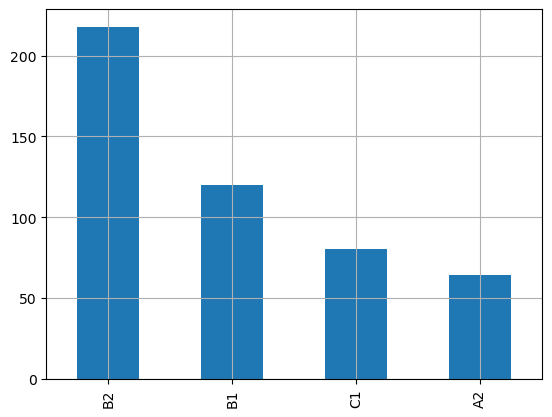

In [31]:
new_df['Level'].value_counts().plot(kind='bar', grid=True)

Также в данных присутствует дисбаланс классов. Для балансировки выборки применим дополнительное разделение субтитров.

In [32]:
parts = []
for _, row in df.iterrows():
    if row['Level'] == 'B1':
        text_a = row["Subtitles"].split()[:len(row["Subtitles"].split()) // 2]
        text_b = row["Subtitles"].split()[len(row["Subtitles"].split()) // 2:]
        parts.append({
            "Subtitles": " ".join(text_a),
            "Level": row["Level"]
        })
        parts.append({
            "Subtitles": " ".join(text_b),
            "Level": row["Level"]
        })
    elif (row['Level'] == 'C1') or (row['Level'] == 'A2'):
        subtitles = row["Subtitles"].split()
        num_words = len(subtitles)
        part_size = num_words // 3
        text_a = subtitles[:part_size]
        text_b = subtitles[part_size:2*part_size]
        text_c = subtitles[2*part_size:]
        parts.append({
            "Subtitles": " ".join(text_a),
            "Level": row["Level"]
        })
        parts.append({
            "Subtitles": " ".join(text_b),
            "Level": row["Level"]
        })
        parts.append({
            "Subtitles": " ".join(text_c),
            "Level": row["Level"]
        })
    else:
        parts.append({
            "Subtitles": row["Subtitles"],
            "Level": row["Level"]
        })

new_df = pd.DataFrame(parts)

Выведем полученное процентное соотношение классов.

In [33]:
new_df['Level'].value_counts(normalize=True) * 100

B1    26.966292
C1    26.966292
B2    24.494382
A2    21.573034
Name: Level, dtype: float64

Данные обработаны и готовы для обучения модели.

### Обучение моделей

Сохраним признаки (субтитры) в переменной X, а целевой признак (уровень) в переменной y.

In [34]:
X, y = new_df['Subtitles'], new_df['Level']

Разделим выборку на обучающую и тестовую в соотношении 3:1.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=326, stratify=y)

Проверим разбиение.

In [36]:
X_train.shape

(333,)

In [37]:
X_test.shape

(112,)

Векторизуем субтитры с помощью TfidfVectorizer.

In [38]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#### Catboost

Зададим pool для обучающей и тестовой выборок.

In [39]:
train_data = Pool(data=X_train,
                  label=y_train)
test_data = Pool(data=X_test,
                  label=y_test)

Зададим параметры и проведем кросс-валидацию.

In [41]:
params = {
    'eval_metric': 'Accuracy',
    'loss_function': 'MultiClass',
    'learning_rate': 0.05,
    'random_seed': 323,
    'verbose': 100,
    'n_estimators': 1500
}

In [42]:
cv_data = cv(
    params=params,
    pool=train_data,
    fold_count=4,
    shuffle=True,
    partition_random_seed=323,
    stratified=True,
    early_stopping_rounds=300)

Training on fold [0/4]
0:	learn: 0.5846774	test: 0.3882353	best: 0.3882353 (0)	total: 498ms	remaining: 12m 26s
100:	learn: 0.9596774	test: 0.6941176	best: 0.7176471 (84)	total: 26.2s	remaining: 6m 3s
200:	learn: 0.9919355	test: 0.7176471	best: 0.7411765 (160)	total: 51.7s	remaining: 5m 34s
300:	learn: 0.9919355	test: 0.7294118	best: 0.7411765 (160)	total: 1m 15s	remaining: 4m 59s
400:	learn: 0.9919355	test: 0.7529412	best: 0.7529412 (375)	total: 1m 29s	remaining: 4m 5s
500:	learn: 0.9959677	test: 0.7411765	best: 0.7529412 (375)	total: 1m 45s	remaining: 3m 30s
600:	learn: 0.9959677	test: 0.7294118	best: 0.7529412 (375)	total: 2m	remaining: 3m

bestTest = 0.7529411765
bestIteration = 375

Training on fold [1/4]
0:	learn: 0.5983936	test: 0.5357143	best: 0.5357143 (0)	total: 168ms	remaining: 4m 12s
100:	learn: 0.9759036	test: 0.5595238	best: 0.5952381 (77)	total: 14.8s	remaining: 3m 25s
200:	learn: 0.9839357	test: 0.6309524	best: 0.6666667 (182)	total: 29.5s	remaining: 3m 10s
300:	learn: 0

In [43]:
cv_data

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
0,0,0.468792,0.085184,0.585608,0.051191,1.367076,0.004604,1.360304,0.003576
1,1,0.510146,0.050845,0.628646,0.026334,1.353188,0.003717,1.340273,0.006205
2,2,0.513631,0.026391,0.673699,0.025151,1.338848,0.003596,1.320342,0.004708
3,3,0.528409,0.041311,0.714720,0.019543,1.327522,0.004734,1.302151,0.004610
4,4,0.507391,0.036411,0.711696,0.004451,1.315977,0.005803,1.284309,0.006672
...,...,...,...,...,...,...,...,...,...
671,671,0.745108,0.042364,0.994004,0.002277,0.677873,0.069045,0.085237,0.023427
672,672,0.745108,0.042364,0.994004,0.002277,0.677784,0.069091,0.085201,0.023475
673,673,0.745108,0.042364,0.994004,0.002277,0.677802,0.069082,0.085192,0.023486
674,674,0.745108,0.042364,0.994004,0.002277,0.677810,0.069077,0.085177,0.023506


In [44]:
cv_data[cv_data['test-Accuracy-mean'] == cv_data['test-Accuracy-mean'].max()]

,iterations,test-Accuracy-mean,test-Accuracy-std,train-Accuracy-mean,train-Accuracy-std,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std
377,377,0.748195,0.058556,0.988996,0.00196,0.718263,0.067744,0.139415,0.006837
378,378,0.748195,0.058556,0.988996,0.00196,0.718123,0.067445,0.138954,0.006770


Наилучший результат достигнут на 377 итерации. Обучим модель на полной выборке.

In [45]:
params = {
    'eval_metric': 'Accuracy',
    'loss_function': 'MultiClass',
    'learning_rate': 0.03,
    'random_seed': 323,
    'verbose': False,
    'n_estimators': 377
}

In [46]:
model = CatBoostClassifier(**params)

In [47]:
model.fit(train_data)

Сделаем предсказания на тестовой выборке, найдем accuracy и balanced_accuracy и выведем матрицу ошибок.

In [48]:
y_pred = model.predict(test_data)

In [49]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.7946428571428571

In [50]:
b_accuracy = balanced_accuracy_score(y_test, y_pred)
b_accuracy

0.7949404761904761

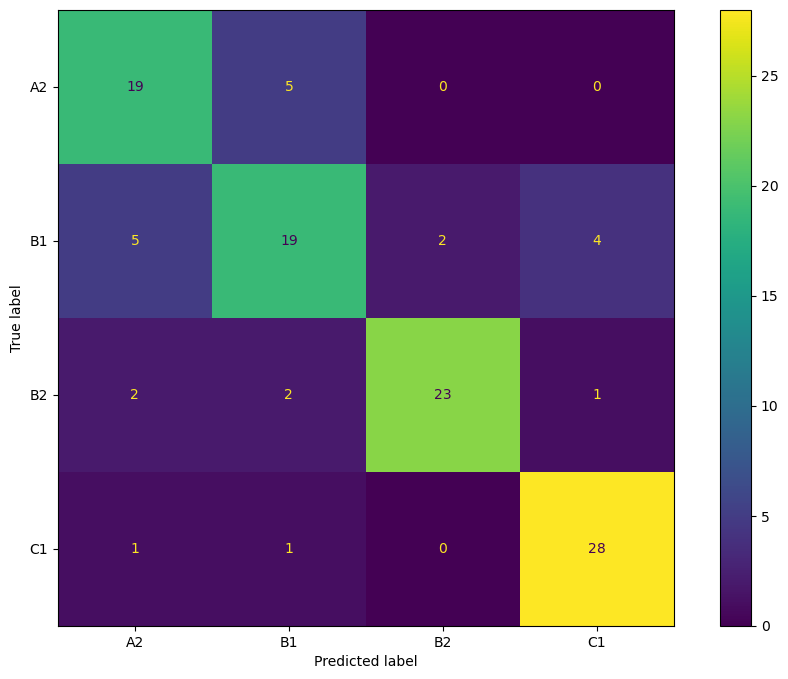

In [51]:
fig, ax = plt.subplots(figsize=(12,8))
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
cmp.plot(ax=ax)
plt.show()

На тестовой выборке достигнута довольно хорошая метрика, balanced accuracy равна 0.795.

Проверим, как модель предсказывает уровень по полным субтитрам.

In [52]:
X_full, y_full = df['Subtitles'], df['Level']

In [53]:
X_full = vectorizer.transform(X_full)

In [54]:
y_pred_full = model.predict(X_full)

In [55]:
b_accuracy = balanced_accuracy_score(y_full, y_pred_full)
b_accuracy

0.7895737767584098

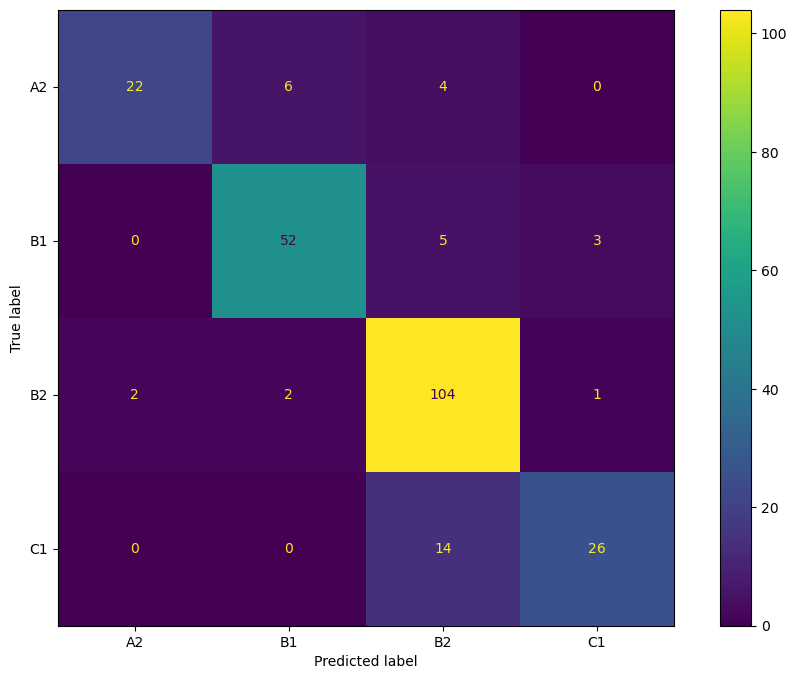

In [56]:
fig, ax = plt.subplots(figsize=(12,8))
cm = confusion_matrix(y_full, y_pred_full)
cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
cmp.plot(ax=ax)
plt.show()

Получился сопоставимый результат.

#### RandomForest

Также обучим модель случайного леса. Для подбора гиперпараметров воспользуемся optuna.

In [57]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    }
    model = RandomForestClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=4, scoring='balanced_accuracy')
    return scores.mean()

In [58]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-06-19 21:22:09,112] A new study created in memory with name: no-name-7cae1b0f-8ba7-4eed-bc04-69fb345b7e10
[I 2023-06-19 21:22:11,060] Trial 0 finished with value: 0.7413304238032499 and parameters: {'n_estimators': 352, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 6, 'max_features': 'auto'}. Best is trial 0 with value: 0.7413304238032499.
[I 2023-06-19 21:22:12,133] Trial 1 finished with value: 0.6985873878536921 and parameters: {'n_estimators': 218, 'max_depth': 36, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.7413304238032499.
[I 2023-06-19 21:22:13,901] Trial 2 finished with value: 0.6220132222849615 and parameters: {'n_estimators': 506, 'max_depth': 22, 'min_samples_split': 3, 'min_samples_leaf': 7, 'max_features': 'log2'}. Best is trial 0 with value: 0.7413304238032499.
[I 2023-06-19 21:22:15,307] Trial 3 finished with value: 0.7367388951628082 and parameters: {'n_estimators': 230, 'max_depth': 25, '

[I 2023-06-19 21:24:35,012] Trial 31 finished with value: 0.777479374490244 and parameters: {'n_estimators': 917, 'max_depth': 33, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.7909779079616036.
[I 2023-06-19 21:24:39,030] Trial 32 finished with value: 0.6896088211305602 and parameters: {'n_estimators': 986, 'max_depth': 35, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 21 with value: 0.7909779079616036.
[I 2023-06-19 21:24:48,736] Trial 33 finished with value: 0.7589989569609135 and parameters: {'n_estimators': 893, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.7909779079616036.
[I 2023-06-19 21:24:51,714] Trial 34 finished with value: 0.6932027965995358 and parameters: {'n_estimators': 771, 'max_depth': 37, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 21 with value: 0.7909779

[I 2023-06-19 21:27:44,055] Trial 62 finished with value: 0.7721132128740824 and parameters: {'n_estimators': 969, 'max_depth': 28, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.7909779079616036.
[I 2023-06-19 21:27:53,189] Trial 63 finished with value: 0.7631197455925716 and parameters: {'n_estimators': 956, 'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.7909779079616036.
[I 2023-06-19 21:27:56,585] Trial 64 finished with value: 0.6815315421293683 and parameters: {'n_estimators': 871, 'max_depth': 33, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 21 with value: 0.7909779079616036.
[I 2023-06-19 21:28:06,453] Trial 65 finished with value: 0.7781106876215572 and parameters: {'n_estimators': 933, 'max_depth': 29, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 21 with value: 0.790977

[I 2023-06-19 21:31:22,258] Trial 93 finished with value: 0.7874054990902817 and parameters: {'n_estimators': 905, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 81 with value: 0.7989124552983248.
[I 2023-06-19 21:31:30,093] Trial 94 finished with value: 0.7628238910847607 and parameters: {'n_estimators': 902, 'max_depth': 22, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 81 with value: 0.7989124552983248.
[I 2023-06-19 21:31:39,454] Trial 95 finished with value: 0.7709776334776335 and parameters: {'n_estimators': 977, 'max_depth': 25, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 'log2'}. Best is trial 81 with value: 0.7989124552983248.
[I 2023-06-19 21:31:43,184] Trial 96 finished with value: 0.683689770374553 and parameters: {'n_estimators': 959, 'max_depth': 18, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 81 with value: 0.7989124

Обучим модель с использованием оптимальных гиперпараметров.

In [59]:
best_params = study.best_params
best_model = RandomForestClassifier(**best_params)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=24, max_features='log2', min_samples_split=6,
                       n_estimators=996)

In [60]:
y_pred = best_model.predict(X_test)

In [61]:
b_accuracy = balanced_accuracy_score(y_test, y_pred)
b_accuracy

0.8330357142857142

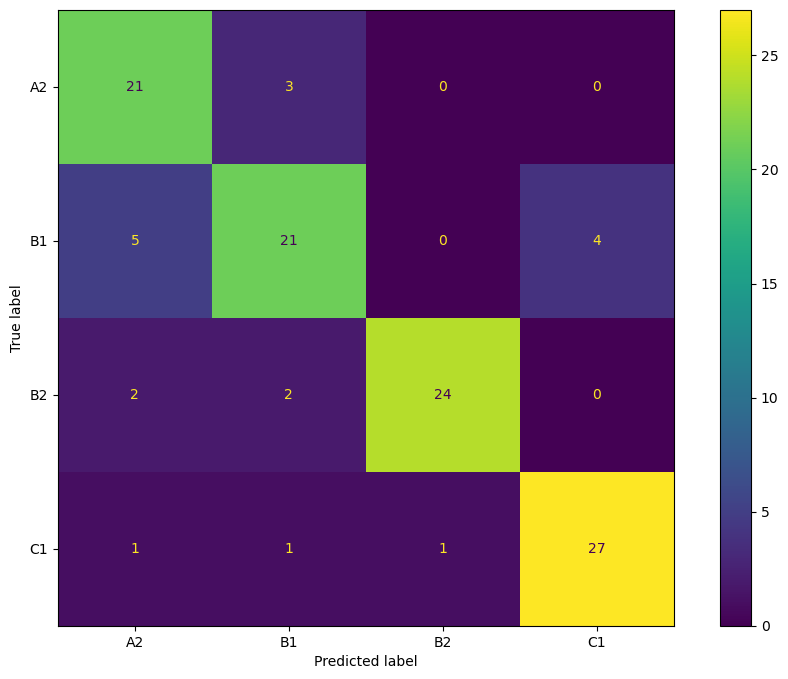

In [62]:
fig, ax = plt.subplots(figsize=(12,8))
cm = confusion_matrix(y_test, y_pred)
cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
cmp.plot(ax=ax)
plt.show()

Balanced accuracy равен 0,83, что лучше, чем у catboost.

In [63]:
y_pred_full = best_model.predict(X_full)

In [64]:
b_accuracy = balanced_accuracy_score(y_full, y_pred_full)
b_accuracy

0.7574923547400612

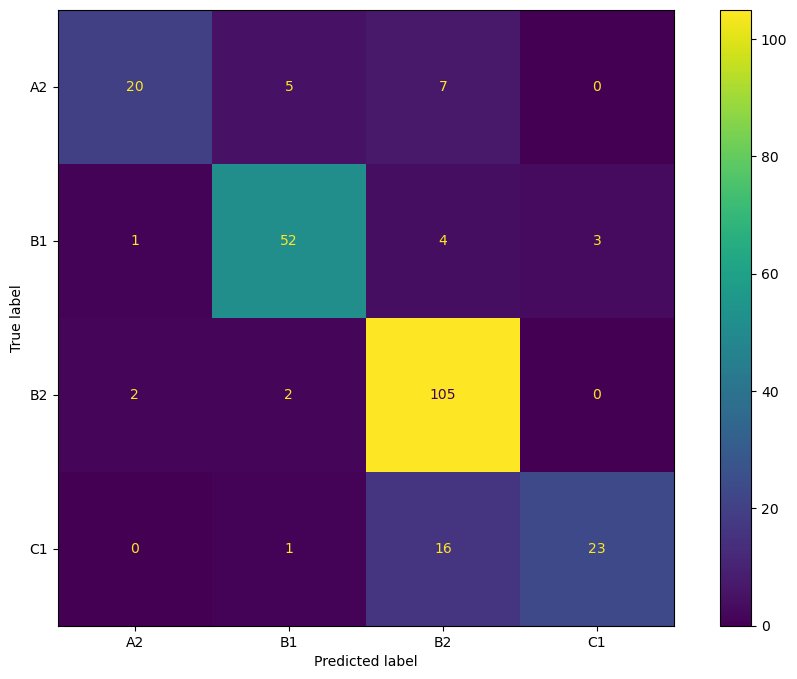

In [65]:
fig, ax = plt.subplots(figsize=(12,8))
cm = confusion_matrix(y_full, y_pred_full)
cmp = ConfusionMatrixDisplay(cm, display_labels = model.classes_ )
cmp.plot(ax=ax)
plt.show()

На полных субтитрах результат немного ухудшился и оказался хуже, чем у CatBoost.

### Вывод

В ходе работы были загружены данные. Фильмы с их оценками были выгружены из файла Excel, а субтитры в формате SRT были загружены с помощью `pysrt`.

Была проведена предобработка и исследовательский анализ данных. В субтитрах были удалены HTML-ссылки, реклама, комментарии, знаки препинания и стоп-слова. Также была проведена лемматизация. Для решения проблемы дисбаланса классов и размера выборки субтитры были разделены на несколько частей.

Были обучены модели CatBoost и случайного леса. Для данной задачи рекомендуется использовать модель CatBoost, так как ее balanced accuracy на полных субтитрах оказалась немного выше (0,79).